In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt
import warnings as wgs
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import PolynomialFeatures 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
wgs.filterwarnings('ignore')
%matplotlib inline

EXTRACTION DES DONNEES DEPUIS LE SITE DE L'INSEE

Il s'agit ici d'extraire les données sur le site de l'Insee pour les nettoyer et enfin les mettre sous forme de tableau pour faciliter l'étude.

In [2]:
# Récupération des données à partir de beautifulsoup 
url=urlopen("https://www.insee.fr/fr/statistiques/6436488#tableau-petrole-g1-fr")

In [ ]:
REG=bs(url,'html')
print(REG.prettify())

In [7]:
h=REG.find('thead')
Titre=h.text.strip().split('\n')
title=[]
title.append('Date')
title.append(Titre[0])
title.append(Titre[1])
title

['Date', 'Prix en devises', 'Prix en euros']

In [4]:
t=REG.find_all('tbody')
M=[]
for j in t[1]:
    M.append(j.text.strip().split('\n'))


In [8]:
#Création du data Frame 
D=pd.DataFrame(M)
D.dropna(inplace=True)
D.columns=title
data=D.copy()
data['Date']=D['Date'].astype('datetime64')
data[title[1:]]=D[title[1:]].astype(float)
data.sort_index(ascending=False,inplace=True)
data.set_index('Date',inplace=True)
data.to_csv("importation_petrole.csv")


In [9]:
# Moyenne fixe sur les périodes antérieures
data["Prix en euros"].mean()

57.218018018018014

In [10]:
!pip install matplotlib

Text(0.5, 1.0, 'prix du Brente de pétrole')

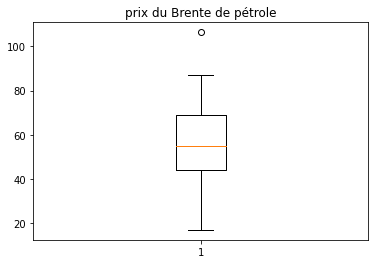

In [13]:
# Boxplot
plt.boxplot(data["Prix en euros"])
plt.title("prix du Brente de pétrole")

On retrouve bien une moyenne d'environ 57.21 euros du prix du Brente de pétrole de Janvier 2013 à Mars 2022 

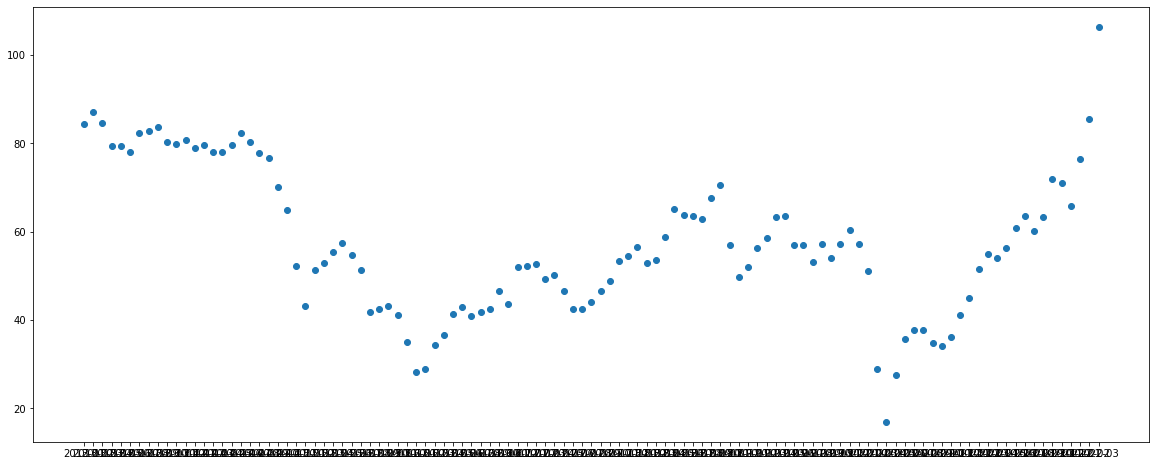

In [52]:
##### Nuage de points
plt.figure(figsize=(20,8))
plt.scatter(x=D["Date"].sort_index(ascending=False),y=data["Prix en euros"].sort_index(ascending=True))


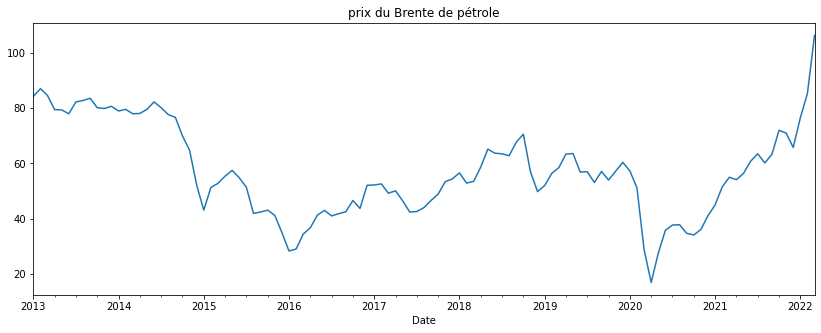

In [40]:
# Prix du pétrole en euro
data["Prix en euros"].plot(figsize=(14,5))
plt.title("prix du Brente de pétrole")
data.sort_index(ascending=False,inplace=True)


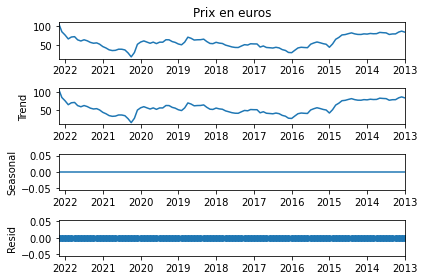

In [28]:
# Décomposition Erreur-saisonnalité-Tendance
seasonal_decompose(data["Prix en euros"], model='additive', freq=1).plot();

Cette décomposition montre en effet une tendance que nous devrons par la suite éliminée pour permettre l'application de modèle inherent aux séries temporelles.

In [20]:
#Fonction permettant d'éxécuter le test de stationnarité et
def get_stationarity(timeseries):
    
    #Statistiques mobiles 
    # calculer la moyenne roulante pour notre df
    rolling_mean = timeseries.rolling(window = 4).mean()
    # calculer l'Ecart-type roulant pour notre df
    rolling_std = timeseries.rolling(window = 4).std()

    # Visulaiser les statistiques mobiles
    plt.plot(timeseries, color='blue', label= 'Origine')
    plt.plot(rolling_mean, color='red', label ='Moyenne mobile')
    plt.plot(rolling_std, color='black', label ='Ecart-type mobile')

    plt.legend(loc='best')
    plt.title('Statistiques roulantes')
    plt.show(block= False)
    
    # Test Dickey-Fuller
    result = adfuller(timeseries,autolag='AIC')
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

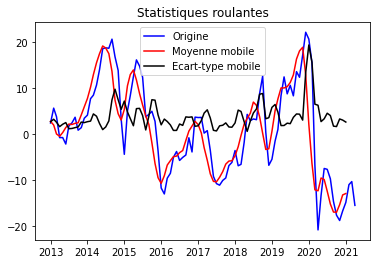

Statistiques ADF : -3.610206041768054
p-value : 0.005568881216682993
Valeurs Critiques :
	1%: -3.4989097606014496
	5%: -2.891516256916761
	10%: -2.5827604414827157


In [26]:
r=data['Prix en euros']-data['Prix en euros'].rolling(window=12).mean()
r.dropna(inplace=True)
get_stationarity(r)
    

Ici le calcul de la moyenne mobile par packets de douze valeurs permet de rendre la série stationnaire.

ETUDE DES FONCTIONS D'AUTOCORRELATION SUR QUARANTE DECALAGES

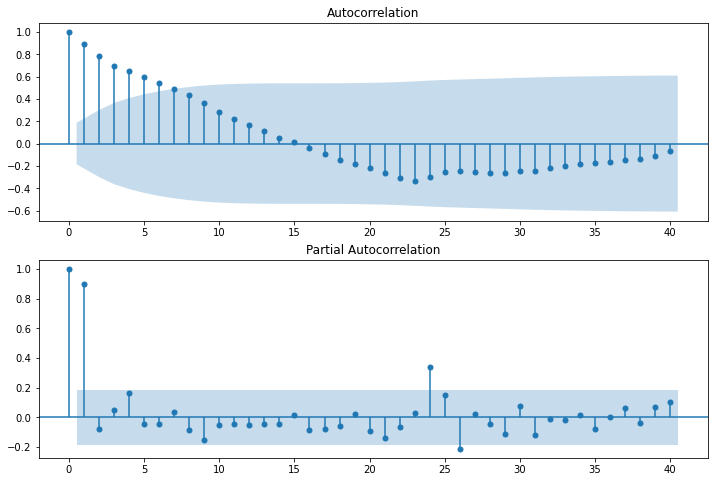

In [30]:

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data['Prix en euros'], lags=40, ax=ax1,)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data['Prix en euros'], lags=40, ax=ax2);

CHOIX D'UN MODELE AVEC DETERMINATI>TION AUTOMATIQUE "Auto_Arima".

In [31]:
from pmdarima import auto_arima
steps=auto_arima(data['Prix en euros'],start_p=0,start_q=0,max_p=8,max_q=8, seasonal=False,trace=True);
steps.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=687.462, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=674.516, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=673.015, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=685.613, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=674.531, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=674.121, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=676.966, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=671.192, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=672.709, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=672.297, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=672.699, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=675.159, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.343 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  111
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -333.596
Date:                Fri, 11 Nov 2022   AIC                            671.192
Time:                        13:12:32   BIC                            676.593
Sample:                             0   HQIC                           673.382
                                - 111                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4009      0.067      6.017      0.000       0.270       0.532
sigma2        25.1760      2.474     10.176      0.000      20.327      30.025
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                28.14
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

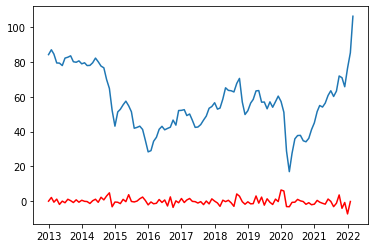

In [34]:
#Entrainement du Modèle Arima
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(data['Prix en euros'], order = (0,1,1))
results = model.fit()
plt.plot(data['Prix en euros'])
plt.plot(results.fittedvalues, color='red')

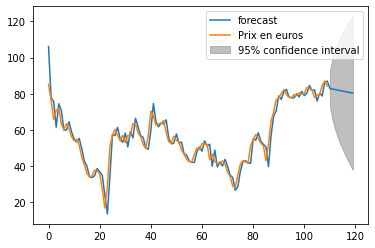

In [35]:
results.plot_predict(1,120);

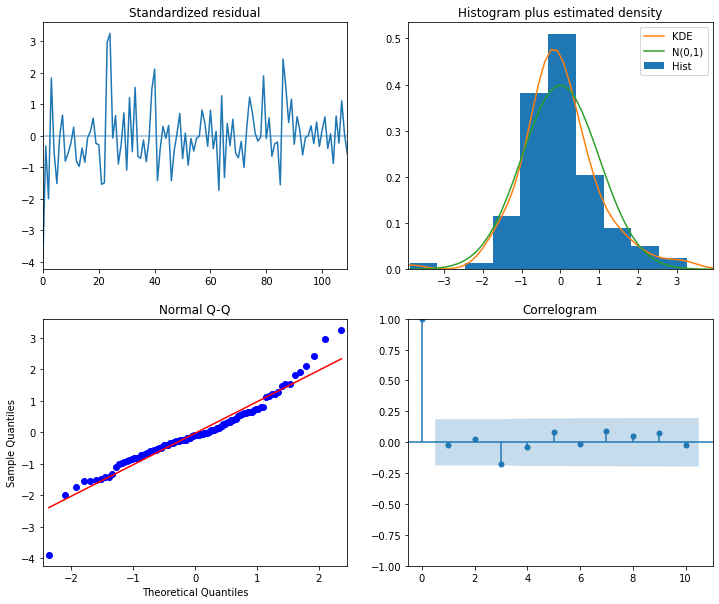

In [36]:
steps.plot_diagnostics(figsize=(12, 10))
plt.show()


In [37]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(steps.resid(),lags=[10], return_df=True)


,lb_stat,lb_pvalue
10,5.621739,0.845979


La p_value est de 0.845979 le modèle choisi est donc pertinent pour la pédiction car, nous avons bien un bruit blanc en teerme résidu.
